In [1]:
# Als je `import clusterizer` typt, dan zoekt Python naar mappen en .py-bestanden met die naam.
# De plekken waar python gaat zoeken staan in de lijst `sys.path`.
# Omdat we nu in SCG-analyse/notebooks zitten, moeten we de bovenliggende map (`SCG-analyse`)
# toevoegen aan de lijst van zoekplekken.
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

# Hiermee wordt de clusterizer module herladen wanneer een bestand ervan verandert
# (handig als je aan de module aan het werken bent).
# Als je dit niet doet, wordt de code (zoals circuit.py, plot.py, etc) alleen geladen wanneer
# je `import clusterizer` typt. 
%load_ext autoreload
%autoreload 2


import clusterizer

import matplotlib.pyplot as plt

# Nodig om een np.datetime64 tijdstip (zoals in de partial_discharges DataFrame) 
# als ascoordinaat te gebruiken.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Hogere DPI voor plotjes (is mooi)
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes in inches
plt.rcParams['figure.figsize'] = [8, 5]

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from clusterizer.cluster import Cluster

Git root path found at: C:\dev\py\SCG-analyse
Using data path:        C:\dev\py\SCG-analyse\data\origineel


In [4]:
circuitje=clusterizer.circuit.MergedCircuit(1512)
circuitje.build()

In [33]:
%%time
pds = circuitje.pd[["Location in meters (m)", "Date/time (UTC)"]][circuitje.pd_occured]
vals = np.array(pds)
for val in vals:
    val[1] = val[1].value/1000000000/60/60/24/7
vals = vals.T 


Wall time: 148 ms


In [34]:
%%time
times = circuitje.pd["Date/time (UTC)"]
starttime = times[0].value/1000000000/60/60/24/7
endtime = times[len(circuitje.pd)-1].value/1000000000/60/60/24/7
endlocation = circuitje.circuitlength
bins = (int(endlocation/2), int(endtime-starttime))
ranges = ((0,endlocation),(starttime,endtime))
bins = np.asarray(bins).astype(np.int64)
ranges = np.asarray(ranges).astype(np.float64)

edges = (np.linspace(*ranges[0,:], bins[0]+1),
         np.linspace(*ranges[1,:], bins[1]+1))

Wall time: 23.2 ms


In [35]:
%%time
cuts = (vals[0]>=ranges[0,0]) & (vals[0]<ranges[0,1]) & (vals[1]>=ranges[1,0]) & (vals[1]<ranges[1,1])
c = ((vals[0,cuts] - ranges[0,0]) / (ranges[0,1] - ranges[0,0]) * bins[0]).astype(np.int_)
c += bins[0]*((vals[1,cuts] - ranges[1,0]) / (ranges[1,1] - ranges[1,0]) * bins[1]).astype(np.int_)
weights = np.bincount(c, minlength=bins[0]*bins[1]).reshape(*bins)
weights = weights.reshape(bins[0]*bins[1],1)
data = np.mgrid[0:bins[1], 0:bins[0]].reshape(2,-1).T.astype(np.float64)
data[:,[0, 1]] = data[:,[1, 0]]
weightedData = np.concatenate((data,weights), axis = 1)
weightedDataNoZero = np.array([row for row in weightedData if row[2] > 0])

Wall time: 37.7 ms


In [36]:
%%time
labels = DBSCAN(eps= 3, min_samples=100).fit(weightedDataNoZero[:, [0,1]], sample_weight = weightedDataNoZero[:, 2] ).labels_
weightedDataNoZero[:,2] = labels   
weightedDataNoZero[:,0] *= endlocation/bins[0]
weightedDataNoZero[:,0] += endlocation/bins[0]/2
weightedDataNoZero[:,1] += (starttime + (endtime-starttime)/bins[1]/2)
clusterAmount = len(set(labels))-1
locLower = [min([row[0] for row in weightedDataNoZero if row[2] == i]) - endlocation/bins[0]/2 for i in range(clusterAmount)]
locUpper = [max([row[0] for row in weightedDataNoZero if row[2] == i]) + endlocation/bins[0]/2 for i in range(clusterAmount)]
timeLower = [np.datetime64(int((min([row[1] for row in weightedDataNoZero if row[2] == i]) - ((endtime-starttime)/bins[1]/2))*60*60*24*7), 's') for i in range(clusterAmount)]
timeUpper = [np.datetime64(int((max([row[1] for row in weightedDataNoZero if row[2] == i]) + ((endtime-starttime)/bins[1]/2))*60*60*24*7), 's') for i in range(clusterAmount)]
clusters = set(Cluster(location_range=(locLower[i], locUpper[i]), time_range=(timeLower[i], timeUpper[i])) for i in range(clusterAmount))

Wall time: 91.4 ms


In [37]:
%%time
times2 = pds["Date/time (UTC)"]
locations = pds["Location in meters (m)"]
clusters2 = set()
for cluster in clusters:
    locationIndex = locations[locations>=cluster.location_range[0]][locations<=cluster.location_range[1]].index
    timeIndex = times[times>=cluster.time_range[0]][times<=cluster.time_range[1]].index
    index = [point for point in locationIndex if point in timeIndex]
    beginTime = np.datetime64(times.loc[index[int(len(index)*0.01)+1]])
    endTime = np.datetime64(times.loc[index[int(len(index)*0.99)-1]])
    locations2 = locations.loc[index].sort_values()
    beginLoc = locations2.iloc[int(len(locations2)*0.01)+1]
    endLoc = locations2.iloc[int(len(locations2)*0.99)-1]
    clusters2.add(Cluster(location_range=(beginLoc, endLoc), time_range=(beginTime, endTime)))


Wall time: 188 ms


<IPython.core.display.Javascript object>


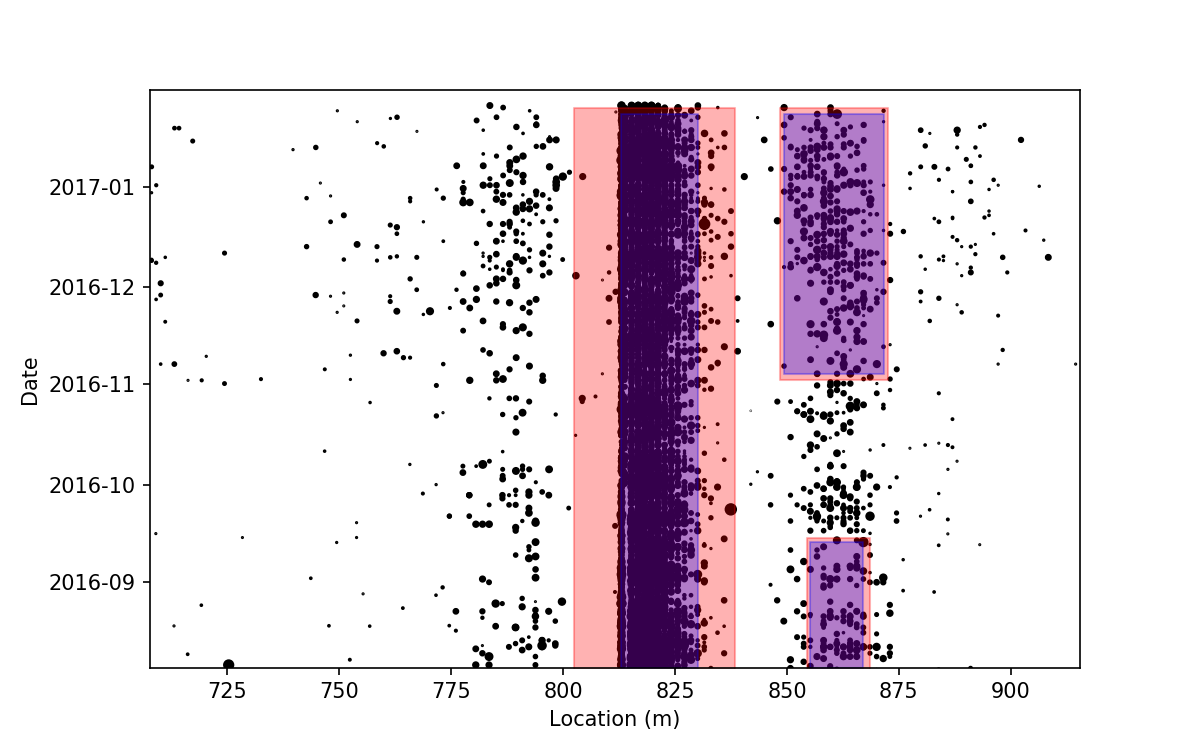

In [38]:
%matplotlib notebook
clusterizer.plot.draw_location_time_scatter(circuitje)
for cluster in clusters:
    clusterizer.plot.overlay_cluster(cluster, ax=None, color="red", opacity=.3)
for cluster2 in clusters2:
    clusterizer.plot.overlay_cluster(cluster2, ax=None, color="blue", opacity=.3)

[2145, 3010, 2979, 2980, 1512, 2063, 2870, 2806]


<IPython.core.display.Javascript object>


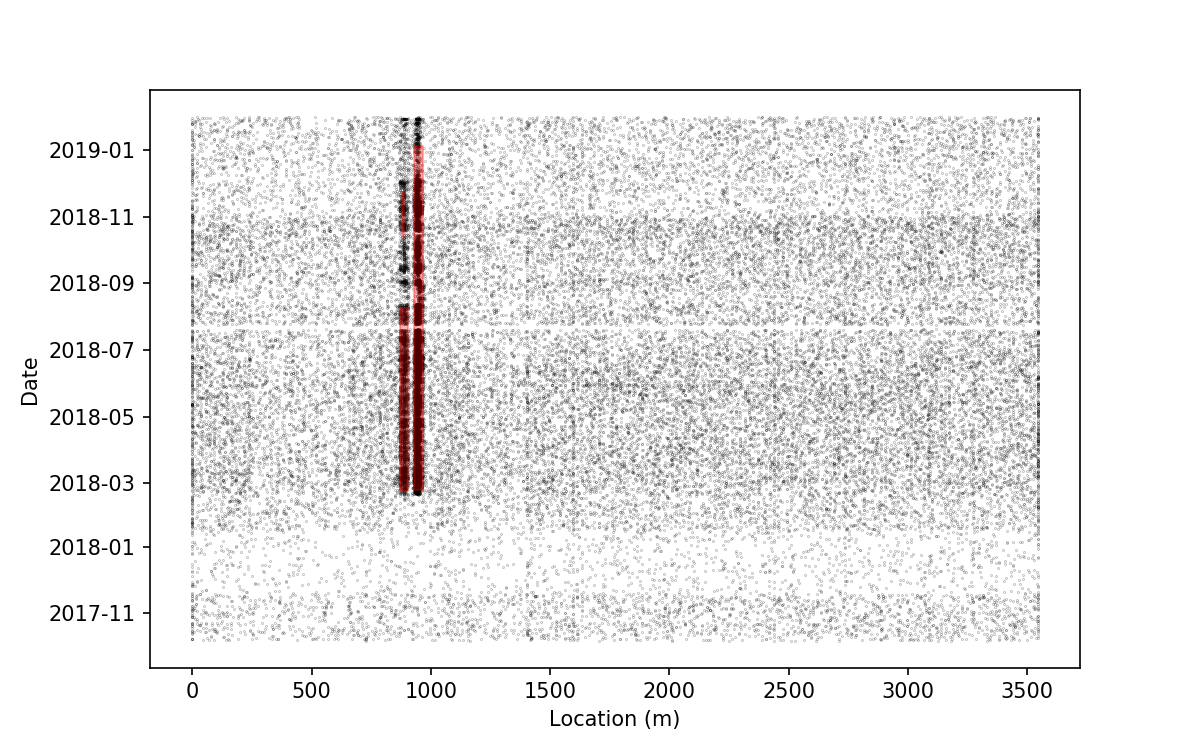

Wall time: 3.59 s


In [45]:
%%time
print(clusterizer.globals.available_circuits)
circuitje=clusterizer.circuit.MergedCircuit(2145)
circuitje.build()

clusters = clusterizer.algorithms.clusterize_DBSCAN(circuitje)

%matplotlib notebook
clusterizer.plot.draw_location_time_scatter(circuitje, dot_size_to_charge_ratio=None)
for cluster in clusters:
    clusterizer.plot.overlay_cluster(cluster, ax=None, color="red", opacity=.3)

In [48]:
circuitje=clusterizer.circuit.MergedCircuit(2145)
circuitje.build()

In [49]:
%%time

clusterizer.algorithms.clusterize_poisson(circuitje)

Wall time: 20.2 ms


({<clusterizer.cluster.Cluster at 0x1b8e69cdfd0>,
  <clusterizer.cluster.Cluster at 0x1b8e65d1fd0>},
 array([   0.,    4.,    8.,   12.,   16.,   20.,   24.,   28.,   32.,
          36.,   40.,   44.,   48.,   52.,   56.,   60.,   64.,   68.,
          72.,   76.,   80.,   84.,   88.,   92.,   96.,  100.,  104.,
         108.,  112.,  116.,  120.,  124.,  128.,  132.,  136.,  140.,
         144.,  148.,  152.,  156.,  160.,  164.,  168.,  172.,  176.,
         180.,  184.,  188.,  192.,  196.,  200.,  204.,  208.,  212.,
         216.,  220.,  224.,  228.,  232.,  236.,  240.,  244.,  248.,
         252.,  256.,  260.,  264.,  268.,  272.,  276.,  280.,  284.,
         288.,  292.,  296.,  300.,  304.,  308.,  312.,  316.,  320.,
         324.,  328.,  332.,  336.,  340.,  344.,  348.,  352.,  356.,
         360.,  364.,  368.,  372.,  376.,  380.,  384.,  388.,  392.,
         396.,  400.,  404.,  408.,  412.,  416.,  420.,  424.,  428.,
         432.,  436.,  440.,  444.,  448.,  452

1512: 273 ms

2063: 310 ms

2145: 1230 ms

2806: 264 ms

2870: 712 ms

2979: 200 ms

2980: 335 ms

3010: 240 ms

Gemiddeld: 446 ms

Max : 1230 ms
